# Задание **Pro**

Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. 

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную.

# Подключение библиотек и дополнительных функций

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, concatenate, Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import librosa
import time
import numpy as np
import os
import scipy.stats
from google.colab import drive, files
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Дополнительные функции

In [ ]:
# Функция параметризации аудио
def get_features(y, sr):

  # --------------------------------------------------------------------------------
  # Признаки из урока 
  # --------------------------------------------------------------------------------
  rmse_mean = np.mean(librosa.feature.rms(y=y))
  spec_cent_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  cpec_bw_mean = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y))

  # --------------------------------------------------------------------------------
  # Добавим новые признаки (среднее значение)
  # --------------------------------------------------------------------------------

  spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))                               # Вычисление спектральной плоскостности
  
 
  # Обнаружение начала
  onset_detect = librosa.onset.onset_detect(y=y, sr=sr, units='time')                               # Нахождение начального события заметки, выбирая пики в огибающей силы начала.
  onset_strength = librosa.onset.onset_strength(y=y, sr=sr)                                         # Вычисление огибающую силы начала спектрального потока
  onset_backtrack = librosa.onset.onset_backtrack(onset_detect, onset_strength)
  onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr) #, channels=[0, 32, 64, 96, 128]) # Вычисление огибающую силы начала спектрального потока по нескольким каналам

  
  # Бит и темп
  tempo, beats = librosa.beat.beat_track(y=y, sr=sr)                                                # Динамическое программирование трекера битов.
  beats = np.mean(beats)
  
  plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr)
  prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
  beats_plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr, prior=prior)

  plp = np.mean(plp)
  beats_plp = np.mean(beats_plp)

  onset_detect = np.mean(onset_detect)
  onset_strength = np.mean(onset_strength)
  onset_backtrack = np.mean(onset_backtrack)
  onset_subbands = np.mean(onset_subbands)

  # --------------------------------------------------------------------------------
  # Признаки из урока
  # --------------------------------------------------------------------------------
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  # --------------------------------------------------------------------------------
  #  Добавим новые признаки по которым в дальнейшем будем проходиться циклом
  # --------------------------------------------------------------------------------

  # Спектральные особенности
  chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)         # Constant-Q хроматограмма
  chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)       # Вычисление варианта цветности «Нормализованная энергия цветности» (CENS)
  melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr) # Вычисление спектрограммы в масштабе мела.
  spectral_contrast = librosa.feature.spectral_contrast(y=y)  # Вычисление спектрального контраста
  poly_features = librosa.feature.poly_features(y=y, sr=sr)   # Получение коэффициента подгонки полинома n-го порядка к столбцам спектрограммы.
  tonnetz = librosa.feature.tonnetz(y=y, sr=sr)               # Вычисление тонального центроида.

  # Особенности ритма
  tempogram = librosa.feature.tempogram(y=y, sr=sr)                   # Вычисление темпограммы: локальная автокорреляция огибающей начальной силы.
  fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)   # Вычисление темпограммы Фурье: кратковременное преобразование Фурье огибающей силы начала.


  # Манипуляции с функциями
  mfcc_delta = librosa.feature.delta(mfcc)                # Вычисление дельта-функции: локальная оценка производной входных данных по выбранной оси.
  mfcc_delta2 = librosa.feature.delta(mfcc, order=2)      # Второго порядка
  stack_memory = librosa.feature.stack_memory(data=y)     # Встраивание краткосрочной истории: вертикальное объединение вектора данных или матрицы с отложенными копиями самих себя.


  # Инверсия признаков
  mfcc_to_mel = librosa.feature.inverse.mfcc_to_mel(mfcc)    # Инвертируемые кепстральные коэффициенты Mel-частоты


  # Бит и темп
  tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
  beats = np.mean(beats)


  # Разложение спектрограммы
  S = np.abs(librosa.stft(y))
  comps, acts = librosa.decompose.decompose(S, n_components=8)  # Разложение матрицы признаков.

  stft = librosa.stft(y)
  H, P = librosa.decompose.hpss(stft)    # Разделение ударных гармоник с медианной фильтрацией (HPSS).

  nn_filter = librosa.decompose.nn_filter(chroma_cqt, aggregate=np.median,metric='cosine')  # Фильтрация по ближайшим соседям.

  rec = librosa.segment.recurrence_matrix(chroma, mode='affinity', metric='cosine', sparse=True)
  chroma_nlm = librosa.decompose.nn_filter(chroma, rec=rec, aggregate=np.average)

  # --------------------------------------------------------------------------------
  #  Добавление в массив всех признаков
  # --------------------------------------------------------------------------------

  out = []
  out.append(rmse_mean)
  out.append(spec_cent_mean)
  out.append(cpec_bw_mean)
  out.append(rolloff_mean)
  out.append(zcr_mean)
  out.append(tempo)
  out.append(beats)
  out.append(plp)
  out.append(beats_plp)
  out.append(onset_detect)
  out.append(onset_strength)
  out.append(onset_backtrack)
  out.append(onset_subbands)


  # С помощью цикла

  for i in chroma_stft:
    out.append(np.mean(i))

  for i in mfcc:
    out.append(np.mean(i))

  for i in chroma_cqt:
    out.append(np.mean(i)) 
  
  for i in chroma_cens:
    out.append(np.mean(i)) 
  
  for i in melspectrogram:
    out.append(np.mean(i)) 
  
  for i in spectral_contrast:
    out.append(np.mean(i)) 
  
  for i in poly_features:
    out.append(np.mean(i)) 
  
  for i in tonnetz:
    out.append(np.mean(i)) 
  
  for i in tempogram:
    out.append(np.mean(i))
  
  for i in fourier_tempogram:
    out.append(np.mean(i))
  
  for i in mfcc_delta:
    out.append(np.mean(i))

  for i in mfcc_delta2:
    out.append(np.mean(i))

  for i in stack_memory:
    out.append(np.mean(i))

  for i in mfcc_to_mel:
    out.append(np.mean(i))

  for i in comps:
    out.append(np.mean(i))
  
  for i in acts:
    out.append(np.mean(i))

  for i in H:
    out.append(np.mean(i))
  
  for i in P:
    out.append(np.mean(i))

  for i in nn_filter:
    out.append(np.mean(i))

  for i in chroma_nlm:
    out.append(np.mean(i))
    

  return out

# Черновик

In [ ]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
mfcc        = librosa.feature.mfcc(y=y, sr=sr)

rmse      = librosa.feature.rms(y=y)
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cpec_bw   = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff   = librosa.feature.spectral_rolloff(y=y, sr=sr)
zcr       = librosa.feature.zero_crossing_rate(y)

rmse_mean      = np.mean(librosa.feature.rms(y=y))
spec_cent_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
cpec_bw_mean   = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
rolloff_mean   = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
zcr_mean       = np.mean(librosa.feature.zero_crossing_rate(y))


In [ ]:
print("chroma_stft: ", chroma_stft.shape)
print("mfcc:        ", mfcc.shape) 
print()
print("rmse:      ", rmse.shape)      
print("spec_cent: ", spec_cent.shape)
print("cpec_bw:   ", cpec_bw.shape)
print("rolloff:   ", rolloff.shape)   
print("zcr:       ", zcr.shape)       
print()
print("rmse_mean: ", rmse_mean.shape)     
print("spec_cent_mean: ", spec_cent_mean.shape) 
print("cpec_bw_mean: ", cpec_bw_mean.shape)   
print("rolloff_mean: ", rolloff_mean.shape)   
print("zcr_mean: ", zcr_mean.shape)       

chroma_stft:  (12, 1293)
mfcc:         (20, 1293)

rmse:       (1, 1293)
spec_cent:  (1, 1293)
cpec_bw:    (1, 1293)
rolloff:    (1, 1293)
zcr:        (1, 1293)

rmse_mean:  ()
spec_cent_mean:  ()
cpec_bw_mean:  ()
rolloff_mean:  ()
zcr_mean:  ()


## Спектральные особенности

In [ ]:
chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)   # Constant-Q хроматограмма
chroma_cqt.shape

(12, 1293)

In [ ]:
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)   # Вычисление варианта цветности «Нормализованная энергия цветности» (CENS)
chroma_cens.shape

(12, 1293)

In [ ]:
melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)   # Вычисление спектрограммы в масштабе мела.
melspectrogram.shape

(128, 1293)

In [ ]:
spectral_flatness = librosa.feature.spectral_flatness(y=y)   # Вычисление спектральной плоскостности
spectral_flatness.shape

(1, 1293)

In [ ]:
poly_features = librosa.feature.poly_features(y=y, sr=sr)   # Получение коэффициента подгонки полинома n-го порядка к столбцам спектрограммы.
poly_features.shape

(2, 1293)

In [ ]:
tonnetz = librosa.feature.tonnetz(y=y, sr=sr)   # Вычисление тонального центроида.
tonnetz.shape

(6, 1293)

## Особенности ритма

In [ ]:
tempogram = librosa.feature.tempogram(y=y, sr=sr)   # Вычисление темпограммы: локальная автокорреляция огибающей начальной силы.
tempogram.shape

(384, 1293)

In [ ]:
fourier_tempogram = librosa.feature.fourier_tempogram(y=y, sr=sr)   # Вычисление темпограммы Фурье: кратковременное преобразование Фурье огибающей силы начала.
fourier_tempogram.shape

(193, 1294)

## Инверсия признаков

In [ ]:
S = np.abs(librosa.stft(y))
mel_spec = librosa.feature.melspectrogram(S=S, sr=sr)
mel_to_stft = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr)


In [ ]:
mel_to_stft.shape

(1025, 1292)

In [ ]:
mel_to_audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr)
print(mel_to_audio.shape)


(660992,)


array([-0.01727477, -0.0126965 , -0.01303568, ..., -0.01497473,
       -0.01395797, -0.01816365], dtype=float32)

In [ ]:
mfcc_to_mel = librosa.feature.inverse.mfcc_to_mel(mfcc)    # Инвертируемые кепстральные коэффициенты Mel-частоты
print(mfcc_to_mel.shape)


(128, 1292)


In [ ]:
mfcc_to_audio = librosa.feature.inverse.mfcc_to_audio(mfcc)    # Преобразование кепстральных коэффициентов Mel-частоты в аудиосигнал
print(mfcc_to_audio.shape)

(660992,)


## Манипуляции с функциями

In [ ]:
mfcc_delta = librosa.feature.delta(mfcc) # Вычисление дельта-функции: локальная оценка производной входных данных по выбранной оси.
mfcc_delta.shape


(20, 1292)

In [ ]:
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
mfcc_delta2.shape


(20, 1292)

In [ ]:
stack_memory = librosa.feature.stack_memory(data=y)      # Встраивание краткосрочной истории: вертикальное объединение вектора данных или матрицы с отложенными копиями самих себя.
stack_memory.shape

(2, 661500)

## Бит и темп

In [ ]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)   # Динамическое программирование трекера битов.

In [ ]:
tempo

143.5546875

In [ ]:
beats

array([  23,   42,   60,   78,   96,  114,  132,  151,  169,  188,  206,
        224,  242,  261,  279,  296,  314,  333,  350,  369,  387,  405,
        423,  440,  460,  479,  497,  515,  534,  552,  571,  589,  607,
        626,  643,  662,  680,  699,  717,  735,  753,  772,  790,  809,
        828,  847,  865,  884,  902,  920,  938,  957,  975,  994, 1012,
       1030, 1048, 1066, 1083, 1101, 1120, 1139, 1156, 1175, 1194, 1212,
       1229, 1249, 1268])

In [ ]:
plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr)
prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
beats_plp = librosa.beat.plp(onset_envelope=onset_strength, sr=sr, prior=prior)

plp = np.mean(plp)
beats_plp = np.mean(beats_plp)

print(np.mean(plp))
print(np.mean(beats_plp))

0.23626184
0.14640981


## Обнаружение начала

In [ ]:
onset_detect = librosa.onset.onset_detect(y=y, sr=sr, units='time')  # Нахождение начального события заметки, выбирая пики в огибающей силы начала.
np.mean(onset_detect)

14.950599996689675

In [ ]:
onset_strength = librosa.onset.onset_strength(y=y, sr=sr)   # Вычисление огибающую силы начала спектрального потока
np.mean(onset_env)

1.1166842

In [ ]:
onset_backtrack = librosa.onset.onset_backtrack(onset_detect, onset_strength)
np.mean(onset_backtrack)

12.956204379562044

In [ ]:
onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr) #, channels=[0, 32, 64, 96, 128])
np.mean(onset_subbands)

1.5208272

## Разложение спектрограммы

In [ ]:
S = np.abs(librosa.stft(y))
comps, acts = librosa.decompose.decompose(S, n_components=8)  # Разложите матрицу признаков.

In [ ]:
comps.shape

(1025, 8)

In [ ]:
acts.shape

(8, 1292)

In [ ]:
stft = librosa.stft(y)
H, P = librosa.decompose.hpss(stft)    # Разделение ударных гармоник с медианной фильтрацией (HPSS).

In [ ]:
H.shape

(1025, 1292)

In [ ]:
P.shape

(1025, 1292)

In [ ]:
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
nn_filter = librosa.decompose.nn_filter(chroma_cqt, aggregate=np.median,metric='cosine')  # Фильтрация по ближайшим соседям.
nn_filter.shape

(12, 1293)

In [ ]:
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
chroma_med = librosa.decompose.nn_filter(chroma,
                                         aggregate=np.median,
                                         metric='cosine')

rec = librosa.segment.recurrence_matrix(chroma, mode='affinity',
                                        metric='cosine', sparse=True)
chroma_nlm = librosa.decompose.nn_filter(chroma, rec=rec,
                                         aggregate=np.average)

In [ ]:
chroma_med

array([[0.30376428, 0.26755592, 0.25611398, ..., 0.39156127, 0.38819838,
        0.387044  ],
       [0.4558832 , 0.37511757, 0.35211432, ..., 0.46121356, 0.45924377,
        0.45694602],
       [1.        , 1.        , 1.        , ..., 0.36474508, 0.35663834,
        0.34434772],
       ...,
       [0.5019324 , 0.5312238 , 0.54955685, ..., 0.494946  , 0.4918694 ,
        0.4918694 ],
       [0.25531244, 0.24894057, 0.23645297, ..., 0.47766888, 0.47861588,
        0.4858256 ],
       [0.3234017 , 0.33721203, 0.33281672, ..., 0.72498584, 0.7377348 ,
        0.79075605]], dtype=float32)

In [ ]:
chroma_nlm

array([[0.29337275, 0.2706628 , 0.25366494, ..., 0.38487464, 0.38028318,
        0.37863612],
       [0.44733945, 0.3886768 , 0.36204913, ..., 0.47017637, 0.4573244 ,
        0.45436972],
       [1.        , 0.99999994, 0.99999994, ..., 0.3520617 , 0.34734106,
        0.34476426],
       ...,
       [0.49370322, 0.5232957 , 0.5566577 , ..., 0.4917869 , 0.49272525,
        0.4945636 ],
       [0.27378854, 0.26060995, 0.25852886, ..., 0.46938375, 0.47185615,
        0.4765386 ],
       [0.3432132 , 0.35990882, 0.35416272, ..., 0.775921  , 0.7938839 ,
        0.8060531 ]], dtype=float32)

In [ ]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
beats = librosa.util.fix_frames(beats, x_min=0, x_max=chroma.shape[1])
chroma_sync = librosa.util.sync(chroma, beats)
chroma_lag = librosa.feature.stack_memory(chroma_sync, n_steps=3, mode='edge')

In [ ]:
chroma_sync.shape

(12, 70)

# Подготовка данных

In [ ]:
# Распаковка архива
!unzip -q '/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/genres.zip'

# получаем список файлов в распакованной папке
genres = os.listdir('genres')

In [ ]:
songname = f'/content/genres/blues/blues.00000.au'                      
y , sr = librosa.load(songname, mono=False)

# Формирование выборок

In [ ]:
# Формирование обучающей выборки
xTrain = []
yTrain=[]

# Циклом проходим по всем жанрам
for i in range(len(genres)):                                   
  curr_time = time.time()                                      
  g = genres[i]                                                
  for filename in os.listdir(f'genres/{g}'):                   
    songname = f'./genres/{g}/{filename}'                      
    y , sr = librosa.load(songname, mono=True, duration=30)    
    out = get_features(y, sr)                                  
    xTrain.append(out)                                         
    yTrain.append(to_categorical(i, len(genres)))        
  
  print("Жанр ", g, " готов за ", round(time.time()- curr_time), "с", sep="")

Жанр rock готов за 931с
Жанр blues готов за 895с
Жанр country готов за 899с
Жанр hiphop готов за 942с
Жанр disco готов за 940с
Жанр classical готов за 907с
Жанр jazz готов за 881с
Жанр pop готов за 914с
Жанр reggae готов за 924с
Жанр metal готов за 955с


На создание выборок ушло 2:33 часа. Поэтому хорошо сохранить все массивы в гугл диск.

In [ ]:
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/xTrain_all_all_all', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/yTrain_all_all_all', yTrain)

In [ ]:
# Обучающую выборку переводим в numpy массивы
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

In [ ]:
print("xTrain: ", xTrain.shape)
print("yTrain: ", yTrain.shape) 

xTrain:  (1000, 4066)
yTrain:  (1000, 10)


In [ ]:
yTrain_class = np.argmax(yTrain, axis=1)

In [ ]:
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/xTrain_all_all_all', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/yTrain_all_all_all', yTrain)

In [ ]:
# xTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/xTrain_all_all_all.npy')
# yTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио/yTrain_all_all_all.npy')

# Разбиение на выборки и нормирование

In [ ]:
 xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain_class, test_size=0.1)

In [ ]:
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(900, 4066)
(100, 4066)
(900,)
(100,)


# Нейронные сети

In [ ]:
# Подключим callback

# Для изменения шага обучения lr
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=10, min_lr=0.001)

# Для сохранения весов
checkpointer = ModelCheckpoint(filepath = 'weights.{epoch:02d}-{val_loss:.4f}.hdf5', monitor= 'val_accuracy', verbose=0, save_best_only=True, save_weights_only = False)

# 1 - Вариант

In [ ]:
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(4066,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='elu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='elu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='elu'))

model.add(BatchNormalization())

model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(xTrain, yTrain, epochs=500, batch_size=50, validation_data=(xTest, yTest), verbose=1,  callbacks=[checkpointer, reduce_lr])

Epoch 1/500
18/18 [==============================] - 1s 25ms/step - loss: 2.1610 - accuracy: 0.2756 - val_loss: 13.6252 - val_accuracy: 0.1400
Epoch 2/500
18/18 [==============================] - 0s 15ms/step - loss: 1.6737 - accuracy: 0.4022 - val_loss: 9.3220 - val_accuracy: 0.1500
Epoch 3/500
18/18 [==============================] - 0s 15ms/step - loss: 1.5089 - accuracy: 0.4611 - val_loss: 5.3886 - val_accuracy: 0.2200
Epoch 4/500
18/18 [==============================] - 0s 15ms/step - loss: 1.3537 - accuracy: 0.5222 - val_loss: 3.2801 - val_accuracy: 0.2400
Epoch 5/500
18/18 [==============================] - 0s 16ms/step - loss: 1.2601 - accuracy: 0.5544 - val_loss: 2.9463 - val_accuracy: 0.2300
Epoch 6/500
18/18 [==============================] - 0s 15ms/step - loss: 1.1355 - accuracy: 0.6033 - val_loss: 2.0978 - val_accuracy: 0.3500
Epoch 7/500
18/18 [==============================] - 0s 16ms/step - loss: 1.1368 - accuracy: 0.5944 - val_loss: 2.2443 - val_accuracy: 0.3200
Epoch

In [ ]:
# Посмотрим на максимальное значение точности на обучающей выборке
max(history.history['val_accuracy'])

0.8600000143051147

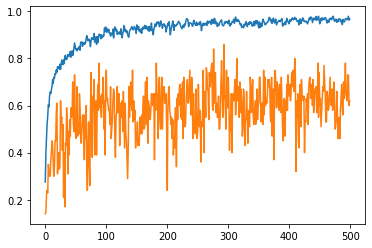

In [ ]:
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(xTrain, yTrain, epochs=500, batch_size=30, validation_data=(xTest, yTest), verbose=1, callbacks=[checkpointer, reduce_lr])

Epoch 1/500
30/30 [==============================] - 1s 18ms/step - loss: 0.1002 - accuracy: 0.9733 - val_loss: 1.2983 - val_accuracy: 0.8000
Epoch 2/500
30/30 [==============================] - 0s 12ms/step - loss: 0.0740 - accuracy: 0.9756 - val_loss: 1.4188 - val_accuracy: 0.8200
Epoch 3/500
30/30 [==============================] - 0s 13ms/step - loss: 0.0587 - accuracy: 0.9822 - val_loss: 1.3045 - val_accuracy: 0.8000
Epoch 4/500
30/30 [==============================] - 0s 12ms/step - loss: 0.0600 - accuracy: 0.9767 - val_loss: 1.0861 - val_accuracy: 0.8100
Epoch 5/500
30/30 [==============================] - 0s 12ms/step - loss: 0.0593 - accuracy: 0.9833 - val_loss: 1.0372 - val_accuracy: 0.8000
Epoch 6/500
30/30 [==============================] - 0s 11ms/step - loss: 0.0585 - accuracy: 0.9844 - val_loss: 1.2061 - val_accuracy: 0.8000
Epoch 7/500
30/30 [==============================] - 0s 12ms/step - loss: 0.0644 - accuracy: 0.9800 - val_loss: 1.2013 - val_accuracy: 0.7600
Epoch 

In [ ]:
max(history.history['val_accuracy'])

0.8399999737739563

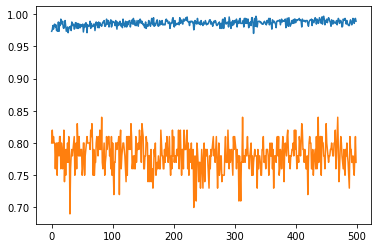

In [ ]:
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(xTrain, yTrain, epochs=500, batch_size=10, validation_data=(xTest, yTest), verbose=1, callbacks=[checkpointer, reduce_lr])

Epoch 1/500
90/90 [==============================] - 2s 10ms/step - loss: 0.1854 - accuracy: 0.9478 - val_loss: 1.3494 - val_accuracy: 0.8000
Epoch 2/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1951 - accuracy: 0.9400 - val_loss: 1.3815 - val_accuracy: 0.8000
Epoch 3/500
90/90 [==============================] - 1s 9ms/step - loss: 0.2266 - accuracy: 0.9400 - val_loss: 1.3367 - val_accuracy: 0.8100
Epoch 4/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1848 - accuracy: 0.9478 - val_loss: 1.4141 - val_accuracy: 0.8100
Epoch 5/500
90/90 [==============================] - 1s 9ms/step - loss: 0.1541 - accuracy: 0.9578 - val_loss: 1.4231 - val_accuracy: 0.7900
Epoch 6/500
90/90 [==============================] - 1s 8ms/step - loss: 0.1897 - accuracy: 0.9456 - val_loss: 1.4392 - val_accuracy: 0.7900
Epoch 7/500
90/90 [==============================] - 1s 8ms/step - loss: 0.1788 - accuracy: 0.9478 - val_loss: 1.4429 - val_accuracy: 0.7900
Epoch 8/500


In [ ]:
max(history.history['val_accuracy'])

0.8199999928474426

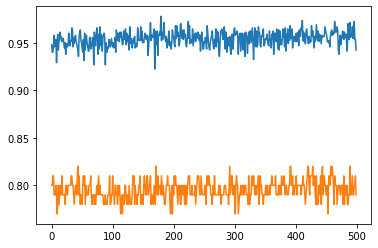

In [ ]:
# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Как видно из графика точность держится в среднем на уровне 80%

# 2 - Вариант

## Сеть с 7 ветками

In [ ]:
input1 = Input(4066,)

x1 = Dense(64, activation='elu')(input1)
x1 = Dense(64, activation='elu')(x1)

x2 = Dense(64, activation='elu')(input1)
x2 = Dense(40, activation='softmax')(x2)

x3 = Dense(64, activation='elu')(input1)
x3 = Dense(200, activation='softmax')(x3)

x4 = Dense(40, activation='softmax')(input1)

x5 = Dense(200, activation='softmax')(input1)

x6 = Dense(10, activation='softmax')(input1)

x7 = Dense(64, activation='elu')(input1)
x7 = Dense(10, activation='softmax')(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Обучение

In [ ]:
historyC_7 = model.fit(xTrain,yTrain, epochs=500, batch_size=50, validation_data=(xTest, yTest),callbacks=[checkpointer, reduce_lr])

Epoch 1/500
18/18 [==============================] - 1s 33ms/step - loss: 8.9145 - accuracy: 0.1322 - val_loss: 2.9148 - val_accuracy: 0.2000
Epoch 2/500
18/18 [==============================] - 0s 22ms/step - loss: 2.3543 - accuracy: 0.3022 - val_loss: 2.1098 - val_accuracy: 0.3300
Epoch 3/500
18/18 [==============================] - 0s 22ms/step - loss: 1.8055 - accuracy: 0.3667 - val_loss: 1.6532 - val_accuracy: 0.4400
Epoch 4/500
18/18 [==============================] - 0s 21ms/step - loss: 1.5753 - accuracy: 0.4400 - val_loss: 1.6529 - val_accuracy: 0.4000
Epoch 5/500
18/18 [==============================] - 0s 21ms/step - loss: 1.5307 - accuracy: 0.4444 - val_loss: 1.6132 - val_accuracy: 0.4500
Epoch 6/500
18/18 [==============================] - 0s 21ms/step - loss: 1.4101 - accuracy: 0.4789 - val_loss: 1.5130 - val_accuracy: 0.4300
Epoch 7/500
18/18 [==============================] - 0s 22ms/step - loss: 1.4726 - accuracy: 0.4722 - val_loss: 1.5017 - val_accuracy: 0.5200
Epoch 

In [ ]:
max(historyC_7.history['val_accuracy'])

0.8299999833106995

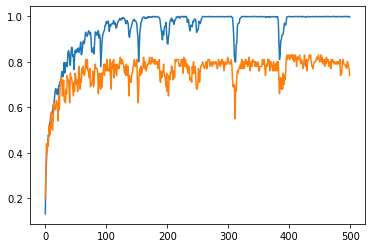

In [ ]:
plt.plot(historyC_7.history["accuracy"])
plt.plot(historyC_7.history["val_accuracy"])
plt.show()

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyC_7 = model.fit(xTrain,yTrain, epochs=1000, batch_size=50, validation_data=(xTest, yTest), callbacks=[checkpointer, reduce_lr])

Epoch 1/1000
18/18 [==============================] - 1s 33ms/step - loss: 0.0101 - accuracy: 0.9956 - val_loss: 2.0537 - val_accuracy: 0.7900
Epoch 2/1000
18/18 [==============================] - 0s 21ms/step - loss: 0.0036 - accuracy: 0.9978 - val_loss: 1.9169 - val_accuracy: 0.7900
Epoch 3/1000
18/18 [==============================] - 0s 21ms/step - loss: 0.0029 - accuracy: 0.9978 - val_loss: 1.9138 - val_accuracy: 0.7800
Epoch 4/1000
18/18 [==============================] - 0s 22ms/step - loss: 0.0029 - accuracy: 0.9978 - val_loss: 1.8835 - val_accuracy: 0.8000
Epoch 5/1000
18/18 [==============================] - 0s 22ms/step - loss: 0.0022 - accuracy: 0.9989 - val_loss: 1.8989 - val_accuracy: 0.7800
Epoch 6/1000
18/18 [==============================] - 0s 21ms/step - loss: 0.0019 - accuracy: 0.9989 - val_loss: 1.9011 - val_accuracy: 0.7900
Epoch 7/1000
18/18 [==============================] - 0s 22ms/step - loss: 0.0022 - accuracy: 0.9978 - val_loss: 1.8903 - val_accuracy: 0.8000

In [ ]:
max(historyC_7.history['val_accuracy'])

0.8100000023841858

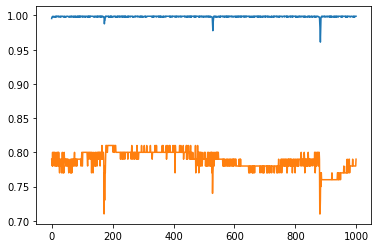

In [ ]:
plt.plot(historyC_7.history["accuracy"])
plt.plot(historyC_7.history["val_accuracy"])
plt.show()

# Выводы:

1. Для достижения данного результата потребовалось провести множество опытов с архитектурами нейронной сети, а также подбором гиперпараметров. 
2. Цели домашнего задания удалось достигнуть путем увеличения входных параметров, увеличение признаков.
3. Для каждой композиции было выявлено:
  - Вычисление хроматограммы из формы волны или спектрограммы мощности.
  - Constant-Q хроматограммы.
  - Вычисление варианта цветности «Нормализованная энергия цветности» (CENS).
  - Вычисление спектрограммы в мел-шкале.
  - Кепстральные коэффициенты Mel-частоты (MFCC).
  - Вычисление среднеквадратичного значения (RMS) для каждого кадра либо из аудиосэмплов, yлибо из спектрограммы S.
  - Вычисление спектрального центроида.
  - Вычисление спектральной полосы частот p-го порядка.
  - Вычисление спектрального контраста
  - Вычисление спектральной плоскостности
  - Вычисление частоты спада.
  - Получение коэффициента подгонки полинома n-го порядка к столбцам спектрограммы.
  - Вычисление тонального центроида (тоннец)
  - Вычисление частоты пересечения нуля временного ряда аудио. 
  - Вычисление темпограммы: локальную автокорреляцию огибающей начальной силы.
  - Вычисление темпограммы Фурье: кратковременное преобразование Фурье огибающей силы начала.
  - Вычисление дельта-функции: локальная оценка производной входных данных по выбранной оси.
  - Вычисление краткосрочной истории: вертикальное объединение вектора данных или матрицы с отложенными копиями самих себя.
  - Преобразование кепстральных коэффициентов Mel-частоты в аудиосигнал во временной области
  - Нахождение начального событития заметки, выбирая пики в огибающей силы начала.
  - Обнаружение начального события до ближайшего предшествующего локального минимума энергетической функции.
  - Вычисление огибающей силы начала спектрального потока.
  - Вычисление огибающей силы начала спектрального потока по нескольким каналам.
  - Динамическое программирование трекера битов.
  - Оценка преобладающего местного пульса (PLP).
  - Оценка темпа (ударов в минуту)
  - Разложение матрицы признаков.
  - Разделение источников гармонических импульсов с медианной фильтрацией (HPSS).
  - Фильтрация по ближайшим соседям.


4. Размероность выборки было (1000,**37**), стала (1000, **4066**)


2. Результат: Точность **86%** на проверочной выборке

    (max(history.history['val_accuracy'])  = **0.86**00000143051147)

3. После дообучения сети с меньшим шагом наблюдается стабильная точность в районе **80%**

4. На другой архитектуре было достигнуто максимальное значение почти **83%**

  ( max(historyC_7.history['val_accuracy']) = **0.8299999**833106995)

5. При обучении сети были изпользованы **callbacks**:

  - **ReduceLROnPlateau** - Для изменения шага обучения
  - **ModelCheckpoint**   - Для сохранения весовых значений

**xTrain**, **xTest**, **yTrain**, **yTest**, а также сохраненные веса для самой лучшей точности на проверочной выборке **weights.294-0.9821.hdf5** для первой модели нейронной сети доступны по ссылке:  https://drive.google.com/drive/folders/1mANWXdcxjab--E4w6BM79wCOX9Heblfl?usp=sharing